# Hierarchical Causal Models 

This notebook is a demonstration of the graphical identification algorithms from [Hierarchical Causal Models](https://arxiv.org/abs/2401.05330) (Weinstein and Blei, 2024).

In [1]:
from IPython.display import SVG
from matplotlib_inline.backend_inline import set_matplotlib_formats

from y0.algorithm.identify import Identification, Query, Unidentifiable, identify, identify_outcomes
from y0.dsl import A, P, U, Variable, Y, Z
from y0.examples import hierarchical as hcme
from y0.graph import NxMixedGraph
from y0.hierarchical import (
    HierarchicalCausalModel,
    QVariable,
    augment_collapsed_model,
    collapse_hcm,
    marginalize_augmented_model,
)

set_matplotlib_formats("svg")


def _draw(hcm: HierarchicalCausalModel) -> SVG:
    graph = hcm.to_pygraphviz()
    graph.layout("dot")
    svg = graph.draw(format="svg:cairo").decode("utf8")
    return SVG(svg)


SchoolTestScore = QVariable.parse_str("Q^Y")
SchoolTutoring = QVariable.parse_str("Q^A")
SchoolScoreGivenTutoring = QVariable.parse_str("Q^{Y|A}")
StudentTutoring, StudentTestScore, SchoolStudySession, SchoolBudget = A, Y, Z, U

## After-school Tutoring and Test Scores 

Consider a school district that is interested in understanding how effective after-school tutuoring is at raising test scores. For each school $i$ in the district, they record the average number of tutoring hours the students receive $\bar{a}_i$ and the average test score of the students $\bar{y}_i$. The school district is interested in the causal query: If students are tutored for $a_\star$ hours, what is the school's expected test score? We write this as
$$ \mathbb{E}\bigl[ \bar{\text{Y}} \; ; \; \text{do}(\bar{a} = a_\star) \bigr]~,$$
where the expectation is taken over the population of schools.  

An issue, however, is that there may be unobserved confounders. Let $u_i$ represent school-specific quantities, like resources, budget, teaching philosophy, etc., which affects _both_ how much tutoring it can dispense and the students' test scores. In the presence of this unobserved confounder, we **cannot** estimate the causal query.

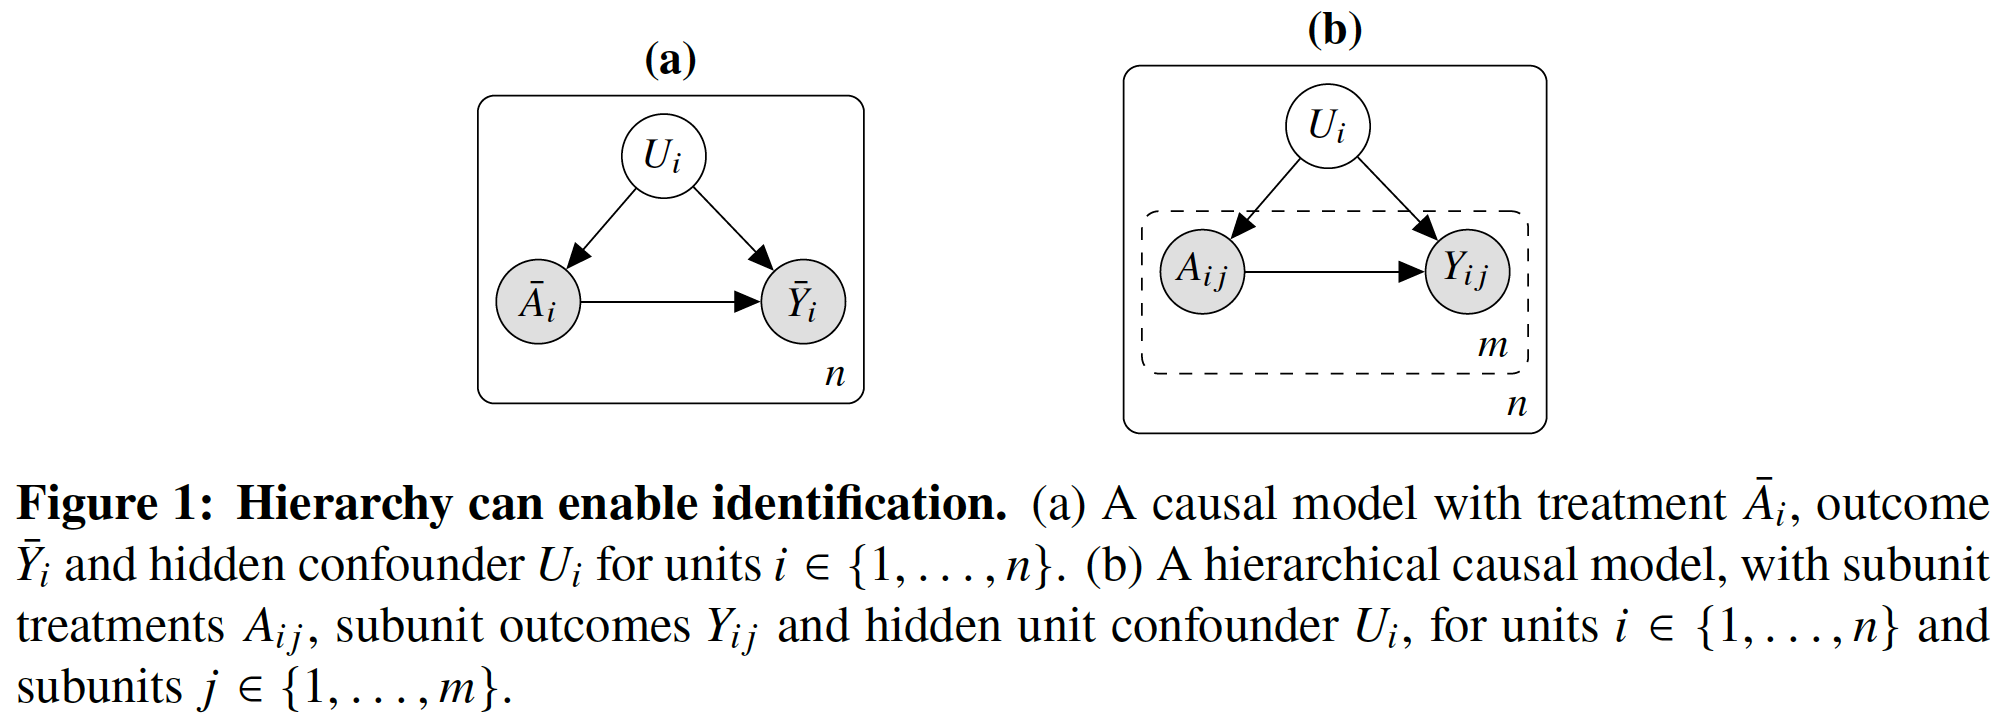

Remember that `y0` utilizes `NxMixedGraph` objects that do not explicitly represent latent variables. Instead, two exogenous variables that are common children of a latent variable are connected with a dashed undirected edge. 

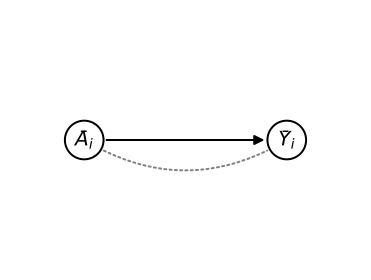

In [2]:
MeanScores, MeanTutoring = Variable("Ȳ_i"), Variable("Ā_i")

school_mean_model = NxMixedGraph.from_edges(
    directed=[(MeanTutoring, MeanScores)], undirected=[(MeanTutoring, MeanScores)]
)
school_mean_model.draw()

In [3]:
scores_do_tutoring = Query(outcomes={MeanScores}, treatments={MeanTutoring})

try:
    identify(
        Identification(
            query=scores_do_tutoring, estimand=P(MeanScores, MeanTutoring), graph=school_mean_model
        )
    )
except Unidentifiable as u:
    print("Unidentifiable: Hedge formed from", u)

Unidentifiable: Hedge formed from (NodeView((Ā_i, Ȳ_i)), {frozenset({Ȳ_i})})


As expected, the causal effect of mean tutoring on mean scores, $ \mathbb{E}\bigl[ \bar{Y} \; ; \; \text{do}(\bar{a} = a_\star) \bigr]$, is not identifiable. 

Now, suppose that instead of only recording the averages for each school, the district also collects the individual data about each student. For student $j$ in school $i$, denote their tutoring hours as $a_{ij}$ and their test score as $y_{ij}$. 

We now have _hierarchical_ data, with a population of _unit-level variables_, the schools in this case, and within each unit-level variable there is a population of _subunit-level variables_, the individual students. Whereas, above we only had unit-level data with averages given for each school. Graphically, we represent sub-unit variables within a rectangular "plate", as shown in Figure 1b above.

Again we ask a causal question: If we set each student's tutoring to $a_\star$ hours, what is the expected test score? We write this quantity as 
$$\mathbb{E}\bigl[Y \; ; \; \text{do}(a=a_\star)\bigr]~,$$
and now the expectation is over the population of students across all schools. 

As we will see, this query _is_ identifiable! Intuitively, the reason for this is that the student-level data provides us information about a natural experiment in which the school-level confounder is held fixed, while the student-level treatment is randomized. 

In our example, we can use the backdoor adjustment to write the intervention in terms of a conditional (given the unobserved school-level confounder $u$),
$$\mathbb{E}\bigl[Y \; ; \; \text{do}(a=a_\star)\bigr] = \int \mathbb{E}\bigl[ Y \; | \; A=a_\star, U=u\bigr] p(u) du~.$$
Then we can use the individual student population data to fit a predictor $\hat{\mu}_i(a) \approx \mathbb{E}\bigl[ Y \; | \; A=a_\star, U=u_i\bigr]$ _for each school_ $i$. The key point here is that, while the confounding variables $u_i$ are not observed, we know that they are fixed to _some_ value for each individual school and this value contributes to the observed distribution of test scores within each school.

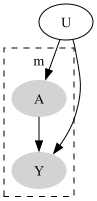

In [4]:
StudentScores, StudentTutoring, SchoolBudget = Variable("Y"), Variable("A"), Variable("U")

hierarchical_model = HierarchicalCausalModel.from_lists(
    observed_subunits=[StudentTutoring, StudentScores],
    unobserved_units=[SchoolBudget],
    edges=[
        (SchoolBudget, StudentTutoring),
        (StudentTutoring, StudentScores),
        (SchoolBudget, StudentScores),
    ],
)

_draw(hierarchical_model)

We now give a brief overview of the graphical algorithms presented in the Hierarchical Causal Models paper that can help us answer whether causal queries on hierarchical data are identifiable. 

### Collapse

The main idea is to "collapse" a hierarchical model into a "flat" model, which then allows us to run the standard graphical identification algorithms, with a few caveats. This is achieved by pushing the subunit-level variables up to the unit level. Recall that each unit-level variable contains within it a population of subunit-level variables. This subunit population can thus be represented at the unit level as a distribution. That is, for school $i$ we represent the distribution over student tutoring hours _within school_ $i$ as a distribution denoted $q^a_i$. Since we also have a population of schools at the unit-level, the variable $Q^a_i$ represents the distribution over the $q^a$ variables across the unit-level population of schools. Thus, upper case Q variables, like $Q^a_i$, are (unit-level) distributions over (subunit-level) distributions. In Hierarchical Causal Models, these are known as _Q variables_, and we represented them with the `QVariable` (sub)class in `y0`. 

Our original hierarchical causal query is translated to a unit-level causal query using the Q variables as:
$$\mathbb{E}[Y \; ; \; \text{do}(q^a = q_\star^a)] = \mathbb{E}_P\bigl[ \mathbb{E}_Q[Y]\; ; \; \text{do}(q^a = q_\star^a)\bigr]~,$$  
$$\mathbb{E}_Q[Y] = \int \int y Q(a,y) \text{d}a \text{d}y = \int y Q(y) \text{d}y~,$$
with the subunit variables drawn from the subunit distribution $Q(a,y)$, which is a realization drawn from the unit-level distribution $Q(a, y) \sim p\bigl(q(a,y)\bigr) \; ; \; \text{do}(q^a = q^a_\star)$.  
At the unit-level, the intervention $q^a = q^a_\star$ fixes the unit-level Q variable to a fixed value, which translates to a soft intervention at the subunit-level, as we are specifying a particular distribution of subunit variables. 

We now call the `collapse_hcm` function on the above hierarchical causal model to create the collapsed model with only unit-level variables. 

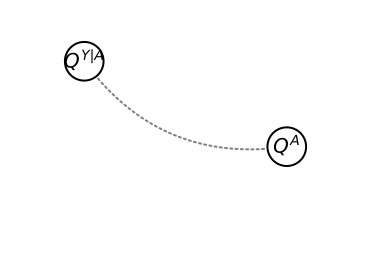

In [5]:
collapsed_model = collapse_hcm(hierarchical_model)
collapsed_model.draw(prog="neato")

In [6]:
for node in collapsed_model.nodes():
    if node == SchoolScoreGivenTutoring:
        print(node)

QVariable(Y, ['A'])


### Augment

There are two important things to note here.  

First, the topology of the subunit-level graph (the part of the graph contained in the inner plate) of the hierarchical causal model is not preserved in the collapsed model. Rather, the edges in the subunit-level graph translate to conditional Q variables (which, recall, are distributions of subunit-level variables). Thus, the $A \rightarrow Y$ edge in the subunit graph translates to the conditional Q variable $Q^{Y|A}$. 

Second, our causal query in this example requires the marginal subunit distribution of the outcome variable $Q(y)$. As we just noted, the subunit-level edge $A  \rightarrow Y$ creates the conditional Q variable $Q^{Y|A}$. We must, therefore, _augment_ our collapsed model to include the marginal subunit distribution $Q(y)$. Because Q variables represent subunit distributions, we can use the chain rule of probability to write $Q(y)$ in terms of unit-level Q variables $Q^A$ and $Q^{Y|A}$,
$$q(y) = \int q^a(a) q^{y|a}(y|a)\text{d}a~.$$

That is, $Q(y)$ is uniquely determined by $Q^A$ and $Q^{Y|A}$. We can thus augment $Q^Y$ into our collapsed model as follows.

First, we need information from the subunit graph of the original hierarchical model (before collapsing). Then we use this to augment $Q^Y$ into our collapsed model. 

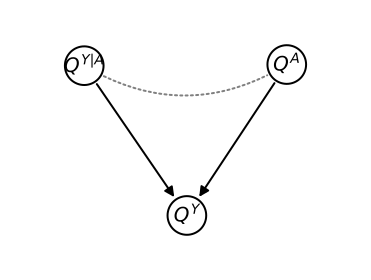

In [7]:
subg = hierarchical_model.get_subunit_graph()
augmented_model = augment_collapsed_model(collapsed_model, subg, "Q^Y")
augmented_model.draw(prog="neato")

We now have the necessary variables for our causal query, and they are all at unit level. Since we have removed the hierarchy specified by the inner plate, we can call standard graphical identification algorithms. 

In [8]:
identify_outcomes(outcomes={SchoolTestScore}, treatments={SchoolTutoring}, graph=augmented_model)

Sum[QVariable(Y, ['A'])](P(QVariable(Y, []) | QVariable(A, []), QVariable(Y, ['A'])) * Sum[QVariable(A, []), QVariable(Y, [])](P(QVariable(A, []), QVariable(Y, []), QVariable(Y, ['A']))))

The hierarchical causal query, which utilizes individual student treament and outcome data instead of mean treamtent and outcomes, is identifiable! 

## Confounder and interference

Let's consider a similar problem with an additional, but important, complication of an interference variable $Z$. In our student tutoring example, this example captures that the subunit-level treatment variables $A_{ij}$ might affect an observable unit-level variable $Z_i$ that, in turn, affects the outcome of all subunits $Y_{ij}$. For instance, if more students are tutored then there may be more school-wide discussion about academic subjects. 

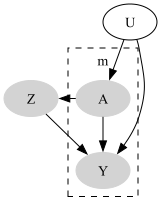

In [9]:
conf_and_int_hcm = hcme.get_confounder_interference_hcm()

_draw(conf_and_int_hcm)

As before, we start by collapsing the hierarchical model to represent subunit-level variables as unit-level Q variables encoding subunit distributions over the subunit variables.

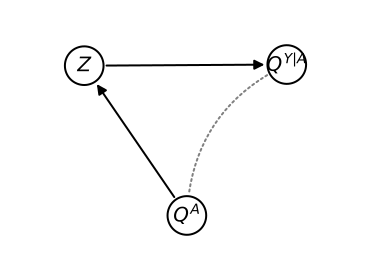

In [10]:
conf_and_int_collapsed = collapse_hcm(conf_and_int_hcm)
conf_and_int_collapsed.draw(prog="neato")

Also as before, we require the marginal subunit distribution for the outcome variable, so must again augment $Q^y$.

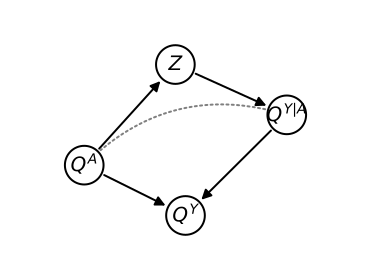

In [11]:
conf_and_int_augmented = augment_collapsed_model(
    conf_and_int_collapsed, conf_and_int_hcm.get_subunit_graph(), "Q^Y"
)
conf_and_int_augmented.draw(prog="dot")

We can now apply do-calculus to identify the causal estimand. We can write the post-intervention distribution of $Q^y$ as,
$$p(q^y \; ; \; \text{do}(q^a=q^a_\star)) = \int p(q^y | q_\star^a q^{y|a}) p(q^{y|a} ; \text{do}(q^a_\star))\text{d}^{y|a}~.$$
The first term is the post-intervention augmented marginal distribution $q^y(y) = \int q^a_\star(a) q^{y|a}(y|a)\text{d}a$. We can identify the second term with a front-door adjustment,
$$p(q^{y|a}; \text{do}(q^a=q^a_\star)) = \int p(z|q^a_\star) \biggl(\int p(q^a) p(q^{y|a} | q^a, z) \text{d}q^a \biggr) \text{d}z~.$$
`y0` will apply the do-calculus for us:

In [12]:
identify_outcomes(graph=conf_and_int_augmented, treatments=SchoolTutoring, outcomes=SchoolTestScore)

Sum[QVariable(Y, ['A']), Z](P(QVariable(Y, []) | QVariable(A, []), QVariable(Y, ['A']), Z) * P(Z | QVariable(A, [])) * Sum[QVariable(A, [])](P(QVariable(A, [])) * P(QVariable(Y, ['A']) | QVariable(A, []), Z)))

## Instrument

For our final example, we examine the instrument motif. Unlike the other two graphs, the outcome variable $Y_i$ is now at the unit level. Further, there is a subunit-level instrument $Z_{ij}$, which exogenously affects the treament $A_{ij}$. For example, $Y_i$ might be a school-level outcome variable, such as whether school $i$ is published in a list of best schools. The instrument $Z_{ij}$ might be a randomly administered incentive for students to enroll in extra tutoring. 

Here, the causal estimand involves a unit-level outcome,
$$\mathbb{E}_p\bigl[Y \; ; \; \text{do}(q^a=a^a_\star)\bigr]~.$$

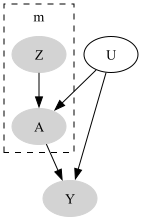

In [13]:
instrument_hcm = hcme.get_instrument_hcm()

_draw(instrument_hcm)

As always, the first step is to create the collapsed model:

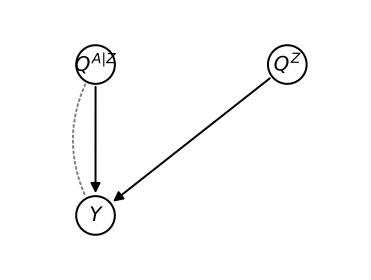

In [14]:
instrument_collapsed = collapse_hcm(instrument_hcm)
instrument_collapsed.draw()

Unlike the prior two cases, we now must augment the treatment variable $Q^a$ because our causal estimand requires the marginal subunit distribution $q^a$ of the treatment variable. Following the chain rule of probability, $Q^A$ is uniquely determined by $Q^Z$ and $Q^{A|Z}$, and we refer to these as the _mechanism_ of $Q^A$. If a mechanism is not specified, `augment_collapsed_model` determines the mechanism from the input subunit graph of the original hierarchical causal model.

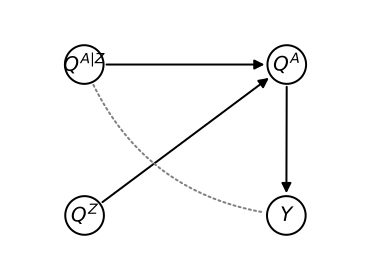

In [15]:
instrument_augmented = augment_collapsed_model(
    instrument_collapsed, instrument_hcm.get_subunit_graph(), "Q^A"
)
instrument_augmented.draw()

To analyze the instrument graph, we need to introduce a new idea: _marginalization_. Because the intervention variable $Q^A$ is fully determined by its parents after agumentation, we may not have _subunit positivity_. That is, the intervention distribution $q^a_\star$ may not be consistent with the observed distributions, $q^z$ and $q^{a|z}$, of its parents since we have that $q^a(a) = \int q^z(z) q^{a|z}(a|z) \text{d}z$.  
To ensure subunit positivity, we marginalize out $Q^Z$ so that $Q^a$ no longer depends deterministically on its parents.

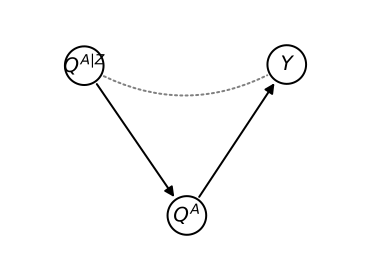

In [16]:
instrument_marg = marginalize_augmented_model(instrument_augmented, "Q^A", ["Q^Z"])
instrument_marg.draw(prog="neato")

With positivity in place, we can use a backdoor adjustment to identify the intervention distribution,
$$p(y \; ; \; \text{do}(q^a=q^a_\star)) = \int p(q^{a|z}) p(y | q^a_\star, q^{a|z}) \text{d}q^{a|z}~.$$ 
Using `y0`, this is indeed what we find:

In [17]:
identify_outcomes(
    graph=instrument_marg,
    treatments=SchoolTutoring,
    outcomes=Y,
)

Sum[QVariable(A, ['Z'])](P(QVariable(A, ['Z'])) * P(Y | QVariable(A, ['Z']), QVariable(A, [])))